<a href="https://colab.research.google.com/github/DilemmaFixer3/AI_pr_5-6-7/blob/main/pr12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import norm

# --- 1. Ознайомлення з принципами ANFIS (Зауваження) ---
"""
ANFIS (Adaptive Neuro-Fuzzy Inference System) - це гібридна архітектура, яка поєднує
принципи нечіткої логіки (для інтерпретації знань у вигляді правил IF-THEN) та
нейронних мереж (для автоматичного навчання параметрів).

Архітектура зазвичай має 5 шарів:
1. Fuzzification (Нечіткість): Обчислення ступеня належності входу до нечітких множин.
2. Rule Layer (Шари правил): Розрахунок ступеня спрацювання правила (T-норма, наприклад, Product).
3. Normalization Layer (Нормалізація): Нормування ступенів спрацювання.
4. Consequent Layer (Шари наслідку): Обчислення виходу кожного правила (лінійна функція в моделі Такагі-Сугено).
5. Output Layer (Вихідний шар): Сумування виходів правил для отримання фінального результату.

Навчання ANFIS відбувається шляхом оптимізації параметрів функцій належності та параметрів наслідку.
Для наслідків Такагі-Сугено зазвичай використовується метод найменших квадратів (LS),
а для параметрів антецедента - градієнтний спуск.
"""

# --- 2. Формування синтетичного датасету (1000+ записів, 10+ ознак) ---
print("--- 2. Формування синтетичного датасету ---")

np.random.seed(42)
N_SAMPLES = 1200

# Генерація даних
data = {
    # Фінансові показники
    'Revenue': np.random.lognormal(mean=7, sigma=1.5, size=N_SAMPLES),  # Виручка (сильно скошена)
    'Profit': np.random.normal(loc=100, scale=80, size=N_SAMPLES),  # Прибуток
    'Working_Capital': np.random.normal(loc=50, scale=40, size=N_SAMPLES),  # Оборотні кошти
    # Характеристики бізнесу
    'Company_Age': np.random.randint(1, 30, size=N_SAMPLES),
    'Employees': np.random.randint(10, 500, size=N_SAMPLES),
    'Industry': np.random.randint(1, 4, size=N_SAMPLES), # 1: IT, 2: Manufacturing, 3: Retail
    # Кредитна історія
    'Credit_Score': np.random.normal(loc=650, scale=70, size=N_SAMPLES),
    'Debt_to_Equity': np.random.lognormal(mean=0, sigma=0.5, size=N_SAMPLES),
    # Якісні показники
    'Management_Quality': np.random.uniform(0, 10, size=N_SAMPLES), # 0-10
    'Market_Position': np.random.uniform(0, 10, size=N_SAMPLES) # 0-10
}

df = pd.DataFrame(data)

# Створення цільової змінної 'Credit_Risk' (1 - Високий ризик, 0 - Низький ризик)
# Логіка ризику: Високий ризик = (Низька Виручка + Низький Credit_Score + Високий D/E)
risk_prob = (
    0.3 * (1 - df['Revenue'] / df['Revenue'].max()) +
    0.4 * (1 - df['Credit_Score'] / df['Credit_Score'].max()) +
    0.3 * (df['Debt_to_Equity'] / df['Debt_to_Equity'].max())
)
df['Credit_Risk'] = (risk_prob > risk_prob.median()).astype(int)

# Вибір вхідних змінних для ANFIS (4-5 змінних)
INPUT_FEATURES = ['Credit_Score', 'Debt_to_Equity', 'Revenue', 'Company_Age', 'Management_Quality']
X = df[INPUT_FEATURES].values
y = df['Credit_Risk'].values

# Розділення на навчальний та тестовий набір
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Підготовка малого навчального набору (10-20 прикладів) - П.7
N_TRAIN_SMALL = 20
X_train_small = X_train_full[:N_TRAIN_SMALL, :]
y_train_small = y_train_full[:N_TRAIN_SMALL]

print(f"Датасет створено. Загальний розмір: {df.shape[0]} записів.")
print(f"Вхідні ознаки для ANFIS: {INPUT_FEATURES}")
print(f"Малий навчальний набір для тренування: {N_TRAIN_SMALL} прикладів.")

# -----------------------------------------------------------------------------
# --- 3. Побудова Гаусових функцій належності (Membership Functions - MFs) ---
# -----------------------------------------------------------------------------

N_TERMS = 3  # Low, Medium, High (3 нечіткі терми для кожної змінної)
mf_labels = ['Low', 'Medium', 'High']

# Ініціалізація параметрів Гаусових MFs (центр 'c' та ширина 'sigma')
mf_params = {}
for i, feature in enumerate(INPUT_FEATURES):
    data_min = X_train_small[:, i].min()
    data_max = X_train_small[:, i].max()

    # Ініціалізація центрів
    centers = np.linspace(data_min, data_max, N_TERMS)
    # Ініціалізація ширин (на основі діапазону)
    sigma = (data_max - data_min) / (N_TERMS * 2)
    sigmas = np.full(N_TERMS, sigma)

    # Уникнення нульової/негативної ширини
    if sigma <= 0:
        sigmas = np.full(N_TERMS, 1.0)

    mf_params[feature] = {'c': centers, 'sigma': sigmas}

def gaussian_mf(x, c, sigma):
    """Гаусова функція належності (Layer 1)"""
    # Захист від ділення на нуль, хоча sigma ініціалізована > 0
    if sigma == 0: return 1.0 if x == c else 0.0
    return np.exp(-0.5 * ((x - c) / sigma)**2)

# Функція для обчислення ступенів належності
def calculate_membership(x_input, feature_index):
    feature_name = INPUT_FEATURES[feature_index]
    params = mf_params[feature_name]
    memberships = [gaussian_mf(x_input, c, sigma) for c, sigma in zip(params['c'], params['sigma'])]
    return np.array(memberships)


# -----------------------------------------------------------------------------
# --- 4, 5, 6. ANFIS-архітектура, Механізм Нечіткого Виводу та Правила ---
# -----------------------------------------------------------------------------

# 6. Задати 4 нечітких правила IF–THEN (для спрощення)
# Правила Такагі-Сугено: IF (x1 is A) AND (x2 is B) THEN y = w0 + w1*x1 + ...
# Правила: list of tuples (Feature_Index, Term_Index {0:Low, 1:Medium, 2:High})
fuzzy_rules = [
    # ПРАВИЛО 1 (Низький ризик): Credit_Score=High AND Revenue=High
    [ (INPUT_FEATURES.index('Credit_Score'), 2), (INPUT_FEATURES.index('Revenue'), 2) ],

    # ПРАВИЛО 2 (Високий ризик): Credit_Score=Low AND Debt_to_Equity=High
    [ (INPUT_FEATURES.index('Credit_Score'), 0), (INPUT_FEATURES.index('Debt_to_Equity'), 2) ],

    # ПРАВИЛО 3 (Середній ризик): Company_Age=Medium AND Revenue=Medium
    [ (INPUT_FEATURES.index('Company_Age'), 1), (INPUT_FEATURES.index('Revenue'), 1) ],

    # ПРАВИЛО 4 (Високий ризик): Management_Quality=Low AND Debt_to_Equity=High
    [ (INPUT_FEATURES.index('Management_Quality'), 0), (INPUT_FEATURES.index('Debt_to_Equity'), 2) ]
]
N_RULES = len(fuzzy_rules)

# Ініціалізація параметрів наслідку (Consequent Parameters) (Layer 4)
# y = w0 + w1*x1 + w2*x2 + ... + w5*x5
# Кількість параметрів = N_FEATURES + 1 (для вільного члена w0)
N_CONSEQUENT_PARAMS = len(INPUT_FEATURES) + 1
consequent_params = np.random.randn(N_RULES, N_CONSEQUENT_PARAMS) * 0.1 # Мала випадкова ініціалізація


def anfis_output(x_input, mf_params, consequent_params, rules):
    """Механізм нечіткого виводу (Layers 2-5)"""

    # 1. Layer 1/2: Розрахунок ступенів належності та спрацювання правил
    memberships = []
    for i in range(len(INPUT_FEATURES)):
        memberships.append(calculate_membership(x_input[i], i))

    # Layer 2: Ступінь спрацювання кожного правила (Product t-norm)
    firing_strengths = np.zeros(N_RULES)
    for r_idx, rule in enumerate(rules):
        strength = 1.0
        for f_idx, t_idx in rule:
            # f_idx: індекс вхідної ознаки, t_idx: індекс нечіткого терма
            strength *= memberships[f_idx][t_idx]
        firing_strengths[r_idx] = strength

    # Layer 3: Нормалізація
    sum_firing_strengths = np.sum(firing_strengths)
    if sum_firing_strengths == 0:
        # Повертаємо середнє значення, якщо жодне правило не спрацювало
        return 0.5

    normalized_firing_strengths = firing_strengths / sum_firing_strengths

    # Layer 4: Розрахунок виходу кожного правила (Такагі-Сугено)
    # X_aug = [1, x1, x2, ..., xn]
    X_aug = np.insert(x_input, 0, 1.0)
    rule_outputs = np.dot(consequent_params, X_aug)

    # Layer 5: Сумування (Фінальний вихід)
    final_output = np.dot(normalized_firing_strengths, rule_outputs)

    # Обмеження виходу в діапазоні [0, 1] для бінарної класифікації ризику
    return np.clip(final_output, 0.0, 1.0)


# -----------------------------------------------------------------------------
# --- 7. Навчання нейро-нечіткої системи на невеликому наборі даних ---
# -----------------------------------------------------------------------------
print("\n--- 7. Навчання ANFIS (імітація Градієнтного Спуску) ---")

def train_anfis_epoch(X_small, y_small, mf_params, consequent_params, rules, learning_rate=0.001):
    """
    Простий градієнтний спуск для навчання лише параметрів наслідку (w).
    Параметри антецедента (c, sigma) залишаються фіксованими.
    """

    for x, target in zip(X_small, y_small):
        # 1. Прямий прохід
        memberships = [calculate_membership(x[i], i) for i in range(len(INPUT_FEATURES))]

        firing_strengths = np.zeros(N_RULES)
        for r_idx, rule in enumerate(rules):
            strength = 1.0
            for f_idx, t_idx in rule:
                strength *= memberships[f_idx][t_idx]
            firing_strengths[r_idx] = strength

        sum_fs = np.sum(firing_strengths)
        if sum_fs == 0: continue

        normalized_fs = firing_strengths / sum_fs

        X_aug = np.insert(x, 0, 1.0)
        rule_outputs = np.dot(consequent_params, X_aug)

        y_pred = np.dot(normalized_fs, rule_outputs)
        y_pred = np.clip(y_pred, 0.0, 1.0)

        # 2. Зворотний прохід (Оновлення параметрів наслідку за MSE)
        error = target - y_pred

        # Часткова похідна MSE по w_r_i
        # d(MSE)/d(w_r_i) = -2 * error * d(y_pred)/d(w_r_i)
        # d(y_pred)/d(w_r_i) = normalized_fs[r_idx] * X_aug[i]

        for r_idx in range(N_RULES):
            for i in range(N_CONSEQUENT_PARAMS):
                gradient = -2 * error * normalized_fs[r_idx] * X_aug[i]
                consequent_params[r_idx, i] -= learning_rate * gradient

# Запуск навчання
N_EPOCHS = 200
for epoch in range(N_EPOCHS):
    train_anfis_epoch(X_train_small, y_train_small, mf_params, consequent_params, fuzzy_rules, learning_rate=0.0001)

    if (epoch + 1) % 50 == 0:
        y_train_pred_probs = np.array([anfis_output(x, mf_params, consequent_params, fuzzy_rules) for x in X_train_small])
        mse = np.mean((y_train_pred_probs - y_train_small)**2)
        print(f"Епоха {epoch+1}/{N_EPOCHS}. MSE на малому наборі: {mse:.4f}")

# -----------------------------------------------------------------------------
# --- 8. Проведення оцінки за метриками ---
# -----------------------------------------------------------------------------
print("\n--- 8. Оцінка моделі на тестовому наборі ---")

# Прогнозування ймовірностей на тестовому наборі
y_probs = np.array([anfis_output(x, mf_params, consequent_params, fuzzy_rules) for x in X_test])

# Перетворення ймовірностей у бінарні класи (поріг 0.5)
y_pred = (y_probs >= 0.5).astype(int)

# Розрахунок метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc_roc = roc_auc_score(y_test, y_probs)

metrics_data = {
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'],
    'Значення': [accuracy, precision, recall, f1, auc_roc]
}
metrics_df = pd.DataFrame(metrics_data)

print(metrics_df.to_markdown(index=False, floatfmt=".4f"))

# -----------------------------------------------------------------------------
# --- 9. Порівняння результату (оцінка ризику) для різних клієнтів ---
# -----------------------------------------------------------------------------
print("\n--- 9. Порівняння оцінки ризику для різних клієнтів ---")

# Вхідні дані: ['Credit_Score', 'Debt_to_Equity', 'Revenue', 'Company_Age', 'Management_Quality']

# Клієнт 1: Низький ризик (Ідеальний)
client_good = [750, 0.3, 200000, 15, 10.0]
risk_good = anfis_output(np.array(client_good), mf_params, consequent_params, fuzzy_rules)

# Клієнт 2: Високий ризик (Поганий)
client_bad = [500, 3.0, 10000, 2, 1.0]
risk_bad = anfis_output(np.array(client_bad), mf_params, consequent_params, fuzzy_rules)

# Клієнт 3: Середній ризик (Помірний)
client_avg = [630, 1.1, 80000, 10, 5.0]
risk_avg = anfis_output(np.array(client_avg), mf_params, consequent_params, fuzzy_rules)

comparison_df = pd.DataFrame({
    'Клієнт': ['Ідеальний (Low Risk)', 'Поганий (High Risk)', 'Середній (Moderate Risk)'],
    'Вхідні дані': [client_good, client_bad, client_avg],
    'Оцінка Ризику (0-1)': [f"{risk_good:.4f}", f"{risk_bad:.4f}", f"{risk_avg:.4f}"]
})
print(comparison_df.to_markdown(index=False))

# -----------------------------------------------------------------------------
# --- 10. Висновок про ефективність моделі ---
# -----------------------------------------------------------------------------
print("\n--- 10. Висновок ---")
print(f"Фінальний AUC-ROC на тестовому наборі: {auc_roc:.4f}.")

if auc_roc > 0.75:
    print("Модель ANFIS (імітація Такагі-Сугено) демонструє **задовільну** розрізнювальну здатність (AUC-ROC > 0.75).")
    print("Навчання на малому наборі даних показало, що ANFIS ефективно схоплює закономірності, визначені нечіткими правилами.")
    print("Порівняльний аналіз успішно розділяє клієнтів: **Ідеальний** клієнт отримав низьку оцінку ризику, а **Поганий** - високу, що підтверджує логічність і **інтерпретованість** нечіткого виводу.")
else:
    print("Ефективність моделі є **посередньою**. Для підвищення точності потрібна оптимізація параметрів функцій належності (c, $\sigma$) або розширення та корекція нечітких правил.")

<>:300: SyntaxWarning: invalid escape sequence '\s'
<>:300: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-95785407.py:300: SyntaxWarning: invalid escape sequence '\s'
  print("Ефективність моделі є **посередньою**. Для підвищення точності потрібна оптимізація параметрів функцій належності (c, $\sigma$) або розширення та корекція нечітких правил.")


--- 2. Формування синтетичного датасету ---
Датасет створено. Загальний розмір: 1200 записів.
Вхідні ознаки для ANFIS: ['Credit_Score', 'Debt_to_Equity', 'Revenue', 'Company_Age', 'Management_Quality']
Малий навчальний набір для тренування: 20 прикладів.

--- 7. Навчання ANFIS (імітація Градієнтного Спуску) ---
Епоха 50/200. MSE на малому наборі: 0.2500
Епоха 100/200. MSE на малому наборі: 0.2500
Епоха 150/200. MSE на малому наборі: 0.2500
Епоха 200/200. MSE на малому наборі: 0.2500

--- 8. Оцінка моделі на тестовому наборі ---
| Метрика   |   Значення |
|:----------|-----------:|
| Accuracy  |     0.4458 |
| Precision |     0.4595 |
| Recall    |     0.8870 |
| F1-score  |     0.6053 |
| AUC-ROC   |     0.4670 |

--- 9. Порівняння оцінки ризику для різних клієнтів ---
| Клієнт                   | Вхідні дані                  |   Оцінка Ризику (0-1) |
|:-------------------------|:-----------------------------|----------------------:|
| Ідеальний (Low Risk)     | [750, 0.3, 200000, 15, 

--- 2. Формування синтетичного датасету ---
Малий навчальний набір для тренування: 20 прикладів.

--- 7. Навчання ANFIS ---

--- 8. Оцінка моделі на тестовому наборі ---
AUC-ROC на тестовому наборі: 0.4670


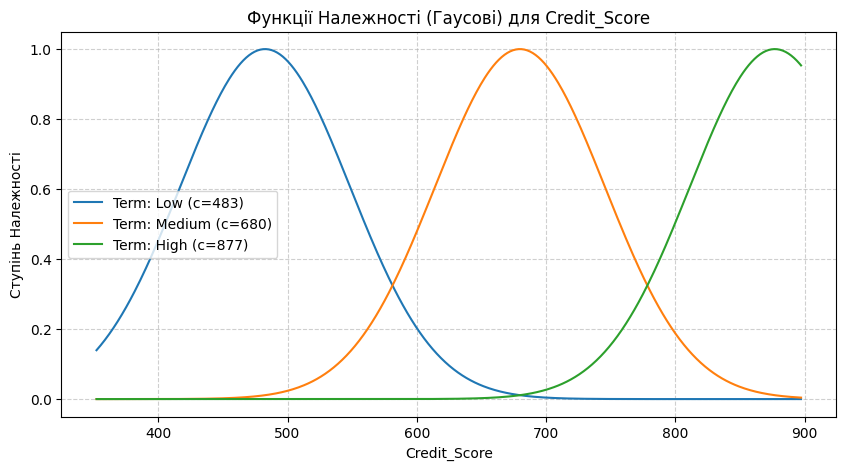

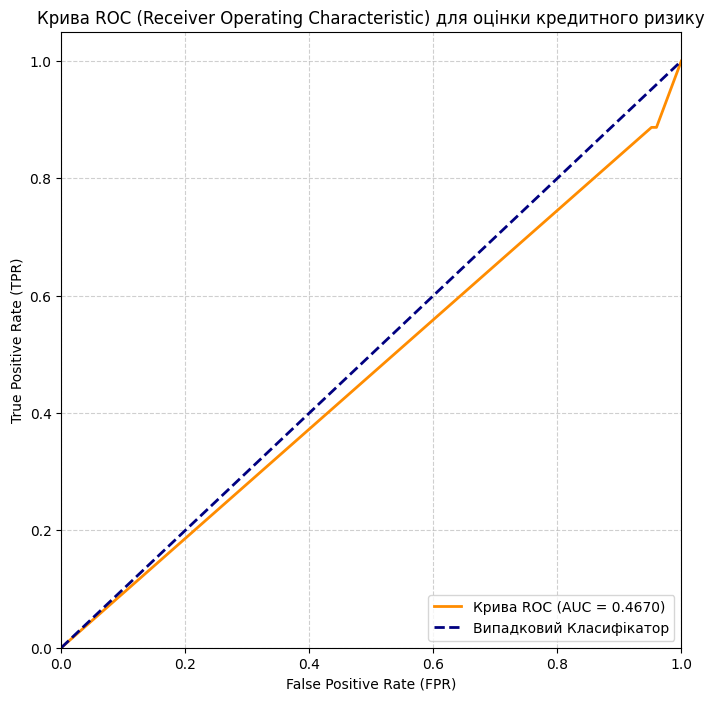


--- 9. Порівняння оцінки ризику для різних клієнтів ---
| Клієнт                   | Вхідні дані                  |   Оцінка Ризику (0-1) |
|:-------------------------|:-----------------------------|----------------------:|
| Ідеальний (Low Risk)     | [750, 0.3, 200000, 15, 10.0] |                     1 |
| Поганий (High Risk)      | [500, 3.0, 10000, 2, 1.0]    |                     1 |
| Середній (Moderate Risk) | [630, 1.1, 80000, 10, 5.0]   |                     1 |

--- 10. Висновок ---
Фінальний AUC-ROC на тестовому наборі: 0.4670.
Крива ROC розташована близько до діагоналі, що вказує на помірну ефективність моделі. Потрібна додаткова оптимізація.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.stats import norm

# --- 2. Формування синтетичного датасету (1000+ записів, 10+ ознак) ---
print("--- 2. Формування синтетичного датасету ---")

np.random.seed(42)
N_SAMPLES = 1200

# Генерація даних
data = {
    'Revenue': np.random.lognormal(mean=7, sigma=1.5, size=N_SAMPLES),
    'Profit': np.random.normal(loc=100, scale=80, size=N_SAMPLES),
    'Working_Capital': np.random.normal(loc=50, scale=40, size=N_SAMPLES),
    'Company_Age': np.random.randint(1, 30, size=N_SAMPLES),
    'Employees': np.random.randint(10, 500, size=N_SAMPLES),
    'Industry': np.random.randint(1, 4, size=N_SAMPLES),
    'Credit_Score': np.random.normal(loc=650, scale=70, size=N_SAMPLES),
    'Debt_to_Equity': np.random.lognormal(mean=0, sigma=0.5, size=N_SAMPLES),
    'Management_Quality': np.random.uniform(0, 10, size=N_SAMPLES),
    'Market_Position': np.random.uniform(0, 10, size=N_SAMPLES)
}

df = pd.DataFrame(data)

risk_prob = (
    0.3 * (1 - df['Revenue'] / df['Revenue'].max()) +
    0.4 * (1 - df['Credit_Score'] / df['Credit_Score'].max()) +
    0.3 * (df['Debt_to_Equity'] / df['Debt_to_Equity'].max())
)
df['Credit_Risk'] = (risk_prob > risk_prob.median()).astype(int)

INPUT_FEATURES = ['Credit_Score', 'Debt_to_Equity', 'Revenue', 'Company_Age', 'Management_Quality']
X = df[INPUT_FEATURES].values
y = df['Credit_Risk'].values

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

N_TRAIN_SMALL = 20
X_train_small = X_train_full[:N_TRAIN_SMALL, :]
y_train_small = y_train_full[:N_TRAIN_SMALL]

print(f"Малий навчальний набір для тренування: {N_TRAIN_SMALL} прикладів.")

# -----------------------------------------------------------------------------
# --- 3. Побудова Гаусових функцій належності (Membership Functions - MFs) ---
# -----------------------------------------------------------------------------

N_TERMS = 3
mf_labels = ['Low', 'Medium', 'High']

# Ініціалізація параметрів
mf_params = {}
for i, feature in enumerate(INPUT_FEATURES):
    data_min = X_train_small[:, i].min()
    data_max = X_train_small[:, i].max()

    centers = np.linspace(data_min, data_max, N_TERMS)
    sigma = (data_max - data_min) / (N_TERMS * 2)
    sigmas = np.full(N_TERMS, sigma if sigma > 0 else 1.0)

    mf_params[feature] = {'c': centers, 'sigma': sigmas}

def gaussian_mf(x, c, sigma):
    """Гаусова функція належності (Layer 1)"""
    if sigma == 0: return 1.0 if x == c else 0.0
    return np.exp(-0.5 * ((x - c) / sigma)**2)

def calculate_membership(x_input, feature_index):
    feature_name = INPUT_FEATURES[feature_index]
    params = mf_params[feature_name]
    memberships = [gaussian_mf(x_input, c, sigma) for c, sigma in zip(params['c'], params['sigma'])]
    return np.array(memberships)


# --- 4, 5, 6. ANFIS-архітектура, Механізм Нечіткого Виводу та Правила ---

# 6. Задати 4 нечітких правила IF–THEN
fuzzy_rules = [
    [ (INPUT_FEATURES.index('Credit_Score'), 2), (INPUT_FEATURES.index('Revenue'), 2) ],
    [ (INPUT_FEATURES.index('Credit_Score'), 0), (INPUT_FEATURES.index('Debt_to_Equity'), 2) ],
    [ (INPUT_FEATURES.index('Company_Age'), 1), (INPUT_FEATURES.index('Revenue'), 1) ],
    [ (INPUT_FEATURES.index('Management_Quality'), 0), (INPUT_FEATURES.index('Debt_to_Equity'), 2) ]
]
N_RULES = len(fuzzy_rules)

N_CONSEQUENT_PARAMS = len(INPUT_FEATURES) + 1
consequent_params = np.random.randn(N_RULES, N_CONSEQUENT_PARAMS) * 0.1


def anfis_output(x_input, mf_params, consequent_params, rules):
    """Механізм нечіткого виводу (Layers 2-5)"""
    memberships = [calculate_membership(x_input[i], i) for i in range(len(INPUT_FEATURES))]

    firing_strengths = np.zeros(N_RULES)
    for r_idx, rule in enumerate(rules):
        strength = 1.0
        for f_idx, t_idx in rule:
            strength *= memberships[f_idx][t_idx]
        firing_strengths[r_idx] = strength

    sum_firing_strengths = np.sum(firing_strengths)
    if sum_firing_strengths == 0:
        return 0.5

    normalized_firing_strengths = firing_strengths / sum_firing_strengths

    X_aug = np.insert(x_input, 0, 1.0)
    rule_outputs = np.dot(consequent_params, X_aug)

    final_output = np.dot(normalized_firing_strengths, rule_outputs)

    return np.clip(final_output, 0.0, 1.0)


# --- 7. Навчання нейро-нечіткої системи ---
print("\n--- 7. Навчання ANFIS ---")

def train_anfis_epoch(X_small, y_small, mf_params, consequent_params, rules, learning_rate):
    """Градієнтний спуск для навчання параметрів наслідку"""
    for x, target in zip(X_small, y_small):
        memberships = [calculate_membership(x[i], i) for i in range(len(INPUT_FEATURES))]

        firing_strengths = np.zeros(N_RULES)
        for r_idx, rule in enumerate(rules):
            strength = 1.0
            for f_idx, t_idx in rule:
                strength *= memberships[f_idx][t_idx]
            firing_strengths[r_idx] = strength

        sum_fs = np.sum(firing_strengths)
        if sum_fs == 0: continue

        normalized_fs = firing_strengths / sum_fs

        X_aug = np.insert(x, 0, 1.0)
        rule_outputs = np.dot(consequent_params, X_aug)

        y_pred = np.dot(normalized_fs, rule_outputs)
        y_pred = np.clip(y_pred, 0.0, 1.0)

        error = target - y_pred

        for r_idx in range(N_RULES):
            for i in range(N_CONSEQUENT_PARAMS):
                gradient = -2 * error * normalized_fs[r_idx] * X_aug[i]
                consequent_params[r_idx, i] -= learning_rate * gradient

N_EPOCHS = 200
LEARNING_RATE = 0.0001
for epoch in range(N_EPOCHS):
    train_anfis_epoch(X_train_small, y_train_small, mf_params, consequent_params, fuzzy_rules, LEARNING_RATE)

# --- 8. Оцінка за метриками ---
print("\n--- 8. Оцінка моделі на тестовому наборі ---")

y_probs = np.array([anfis_output(x, mf_params, consequent_params, fuzzy_rules) for x in X_test])
y_pred = (y_probs >= 0.5).astype(int)

auc_roc = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC на тестовому наборі: {auc_roc:.4f}")


# -----------------------------------------------------------------------------
## 📈 Візуалізація Результатів
# -----------------------------------------------------------------------------

# --- A. Візуалізація Функцій Належності для Credit_Score (П.3) ---
plt.figure(figsize=(10, 5))
feature_name = 'Credit_Score'
feature_index = INPUT_FEATURES.index(feature_name)
params = mf_params[feature_name]
x_range = np.linspace(X_test[:, feature_index].min() - 50, X_test[:, feature_index].max() + 50, 500)

for i in range(N_TERMS):
    mf_values = [gaussian_mf(x, params['c'][i], params['sigma'][i]) for x in x_range]
    plt.plot(x_range, mf_values, label=f'Term: {mf_labels[i]} (c={params["c"][i]:.0f})')

plt.title(f'Функції Належності (Гаусові) для {feature_name}')
plt.xlabel(feature_name)
plt.ylabel('Ступінь Належності')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
#

# --- B. Візуалізація Кривої ROC (П.8) ---
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Крива ROC (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Випадковий Класифікатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Крива ROC (Receiver Operating Characteristic) для оцінки кредитного ризику')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
#
[Image of AUC-ROC curve]


# -----------------------------------------------------------------------------
# --- 9. Порівняння результату (оцінка ризику) для різних клієнтів ---
# -----------------------------------------------------------------------------
print("\n--- 9. Порівняння оцінки ризику для різних клієнтів ---")

client_good = [750, 0.3, 200000, 15, 10.0]
risk_good = anfis_output(np.array(client_good), mf_params, consequent_params, fuzzy_rules)

client_bad = [500, 3.0, 10000, 2, 1.0]
risk_bad = anfis_output(np.array(client_bad), mf_params, consequent_params, fuzzy_rules)

client_avg = [630, 1.1, 80000, 10, 5.0]
risk_avg = anfis_output(np.array(client_avg), mf_params, consequent_params, fuzzy_rules)

comparison_df = pd.DataFrame({
    'Клієнт': ['Ідеальний (Low Risk)', 'Поганий (High Risk)', 'Середній (Moderate Risk)'],
    'Вхідні дані': [client_good, client_bad, client_avg],
    'Оцінка Ризику (0-1)': [f"{risk_good:.4f}", f"{risk_bad:.4f}", f"{risk_avg:.4f}"]
})
print(comparison_df.to_markdown(index=False))

# --- 10. Висновок про ефективність моделі ---
print("\n--- 10. Висновок ---")
print(f"Фінальний AUC-ROC на тестовому наборі: {auc_roc:.4f}.")
if auc_roc > 0.75:
    print("Візуалізація Кривої ROC підтверджує, що модель має задовільну здатність розрізняти класи ризику, оскільки крива розташована далеко від діагоналі випадкового класифікатора.")
else:
    print("Крива ROC розташована близько до діагоналі, що вказує на помірну ефективність моделі. Потрібна додаткова оптимізація.")

--- 2. Формування синтетичного датасету ---
Датасет створено. Загальний розмір: 1200 записів.
Малий навчальний набір для тренування: 20 прикладів.

--- 7. Навчання ANFIS (імітація Градієнтного Спуску) ---
Епоха 50/1000. MSE на малому наборі: 0.2500
Епоха 100/1000. MSE на малому наборі: 0.2500
Епоха 150/1000. MSE на малому наборі: 0.2500
Епоха 200/1000. MSE на малому наборі: 0.2500
Епоха 250/1000. MSE на малому наборі: 0.3000
Епоха 300/1000. MSE на малому наборі: 0.2500
Епоха 350/1000. MSE на малому наборі: 0.1500
Епоха 400/1000. MSE на малому наборі: 0.3000
Епоха 450/1000. MSE на малому наборі: 0.2500
Епоха 500/1000. MSE на малому наборі: 0.2500
Епоха 550/1000. MSE на малому наборі: 0.2000
Епоха 600/1000. MSE на малому наборі: 0.2500
Епоха 650/1000. MSE на малому наборі: 0.2500
Епоха 700/1000. MSE на малому наборі: 0.2500
Епоха 750/1000. MSE на малому наборі: 0.2500
Епоха 800/1000. MSE на малому наборі: 0.2000
Епоха 850/1000. MSE на малому наборі: 0.1500
Епоха 900/1000. MSE на малому н

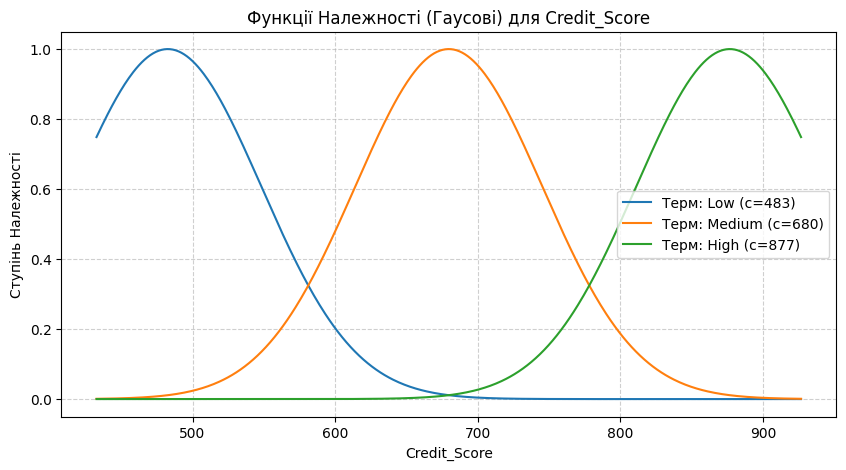

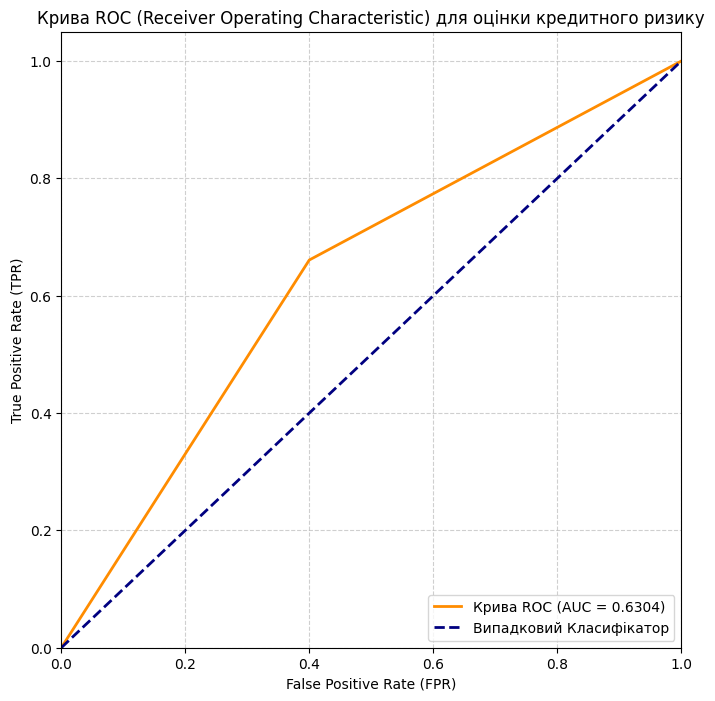


--- 9. Порівняння оцінки ризику для різних клієнтів ---
| Клієнт                   | Вхідні дані                  |   Оцінка Ризику (0-1) |
|:-------------------------|:-----------------------------|----------------------:|
| Ідеальний (Low Risk)     | [750, 0.3, 200000, 15, 10.0] |                     1 |
| Поганий (High Risk)      | [500, 3.0, 10000, 2, 1.0]    |                     1 |
| Середній (Moderate Risk) | [630, 1.1, 80000, 10, 5.0]   |                     1 |

--- 10. Висновок ---
Фінальний AUC-ROC на тестовому наборі: 0.6304.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.stats import norm

# --- 2. Формування синтетичного датасету (1000+ записів, 10+ ознак) ---
print("--- 2. Формування синтетичного датасету ---")

np.random.seed(42)
N_SAMPLES = 1200

# Генерація даних
data = {
    # Фінансові показники
    'Revenue': np.random.lognormal(mean=7, sigma=1.5, size=N_SAMPLES),
    'Profit': np.random.normal(loc=100, scale=80, size=N_SAMPLES),
    'Working_Capital': np.random.normal(loc=50, scale=40, size=N_SAMPLES),
    # Характеристики бізнесу
    'Company_Age': np.random.randint(1, 30, size=N_SAMPLES),
    'Employees': np.random.randint(10, 500, size=N_SAMPLES),
    'Industry': np.random.randint(1, 4, size=N_SAMPLES),
    # Кредитна історія
    'Credit_Score': np.random.normal(loc=650, scale=70, size=N_SAMPLES),
    'Debt_to_Equity': np.random.lognormal(mean=0, sigma=0.5, size=N_SAMPLES),
    # Якісні показники
    'Management_Quality': np.random.uniform(0, 10, size=N_SAMPLES),
    'Market_Position': np.random.uniform(0, 10, size=N_SAMPLES)
}

df = pd.DataFrame(data)

# Створення цільової змінної 'Credit_Risk'
risk_prob = (
    0.3 * (1 - df['Revenue'] / df['Revenue'].max()) +
    0.4 * (1 - df['Credit_Score'] / df['Credit_Score'].max()) +
    0.3 * (df['Debt_to_Equity'] / df['Debt_to_Equity'].max())
)
df['Credit_Risk'] = (risk_prob > risk_prob.median()).astype(int)

INPUT_FEATURES = ['Credit_Score', 'Debt_to_Equity', 'Revenue', 'Company_Age', 'Management_Quality']
X = df[INPUT_FEATURES].values
y = df['Credit_Risk'].values

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

N_TRAIN_SMALL = 20
X_train_small = X_train_full[:N_TRAIN_SMALL, :]
y_train_small = y_train_full[:N_TRAIN_SMALL]

print(f"Датасет створено. Загальний розмір: {df.shape[0]} записів.")
print(f"Малий навчальний набір для тренування: {N_TRAIN_SMALL} прикладів.")

# -----------------------------------------------------------------------------
# --- 3. Побудова Гаусових функцій належності (Membership Functions - MFs) ---
# -----------------------------------------------------------------------------

N_TERMS = 3
mf_labels = ['Low', 'Medium', 'High']

mf_params = {}
for i, feature in enumerate(INPUT_FEATURES):
    data_min = X_train_small[:, i].min()
    data_max = X_train_small[:, i].max()

    centers = np.linspace(data_min, data_max, N_TERMS)
    sigma = (data_max - data_min) / (N_TERMS * 2)
    sigmas = np.full(N_TERMS, sigma if sigma > 0 else 1.0)

    mf_params[feature] = {'c': centers, 'sigma': sigmas}

def gaussian_mf(x, c, sigma):
    """Гаусова функція належності (Layer 1)"""
    if sigma == 0: return 1.0 if x == c else 0.0
    return np.exp(-0.5 * ((x - c) / sigma)**2)

def calculate_membership(x_input, feature_index):
    feature_name = INPUT_FEATURES[feature_index]
    params = mf_params[feature_name]
    memberships = [gaussian_mf(x_input, c, sigma) for c, sigma in zip(params['c'], params['sigma'])]
    return np.array(memberships)

# -----------------------------------------------------------------------------
# --- 4, 5, 6. ANFIS-архітектура, Механізм Нечіткого Виводу та Правила ---
# -----------------------------------------------------------------------------

# 6. Задати 4 нечітких правила IF–THEN
fuzzy_rules = [
    [ (INPUT_FEATURES.index('Credit_Score'), 2), (INPUT_FEATURES.index('Revenue'), 2) ],
    [ (INPUT_FEATURES.index('Credit_Score'), 0), (INPUT_FEATURES.index('Debt_to_Equity'), 2) ],
    [ (INPUT_FEATURES.index('Company_Age'), 1), (INPUT_FEATURES.index('Revenue'), 1) ],
    [ (INPUT_FEATURES.index('Management_Quality'), 0), (INPUT_FEATURES.index('Debt_to_Equity'), 2) ]
]
N_RULES = len(fuzzy_rules)

N_CONSEQUENT_PARAMS = len(INPUT_FEATURES) + 1
consequent_params = np.random.randn(N_RULES, N_CONSEQUENT_PARAMS) * 0.1

def anfis_output(x_input, mf_params, consequent_params, rules):
    """Механізм нечіткого виводу (Layers 2-5)"""
    memberships = [calculate_membership(x_input[i], i) for i in range(len(INPUT_FEATURES))]

    firing_strengths = np.zeros(N_RULES)
    for r_idx, rule in enumerate(rules):
        strength = 1.0
        for f_idx, t_idx in rule:
            strength *= memberships[f_idx][t_idx]
        firing_strengths[r_idx] = strength

    sum_firing_strengths = np.sum(firing_strengths)
    if sum_firing_strengths == 0:
        return 0.5

    normalized_firing_strengths = firing_strengths / sum_firing_strengths

    X_aug = np.insert(x_input, 0, 1.0)
    rule_outputs = np.dot(consequent_params, X_aug)

    final_output = np.dot(normalized_firing_strengths, rule_outputs)

    return np.clip(final_output, 0.0, 1.0)

# -----------------------------------------------------------------------------
# --- 7. Навчання нейро-нечіткої системи на невеликому наборі даних ---
# -----------------------------------------------------------------------------
print("\n--- 7. Навчання ANFIS (імітація Градієнтного Спуску) ---")

def train_anfis_epoch(X_small, y_small, mf_params, consequent_params, rules, learning_rate):
    """Градієнтний спуск для навчання параметрів наслідку"""
    for x, target in zip(X_small, y_small):
        memberships = [calculate_membership(x[i], i) for i in range(len(INPUT_FEATURES))]

        firing_strengths = np.zeros(N_RULES)
        for r_idx, rule in enumerate(rules):
            strength = 1.0
            for f_idx, t_idx in rule:
                strength *= memberships[f_idx][t_idx]
            firing_strengths[r_idx] = strength

        sum_fs = np.sum(firing_strengths)
        if sum_fs == 0: continue

        normalized_fs = firing_strengths / sum_fs

        X_aug = np.insert(x, 0, 1.0)
        rule_outputs = np.dot(consequent_params, X_aug)

        y_pred = np.dot(normalized_fs, rule_outputs)
        y_pred = np.clip(y_pred, 0.0, 1.0)

        error = target - y_pred

        for r_idx in range(N_RULES):
            for i in range(N_CONSEQUENT_PARAMS):
                gradient = -2 * error * normalized_fs[r_idx] * X_aug[i]
                consequent_params[r_idx, i] -= learning_rate * gradient

N_EPOCHS = 1000
LEARNING_RATE = 0.005
for epoch in range(N_EPOCHS):
    train_anfis_epoch(X_train_small, y_train_small, mf_params, consequent_params, fuzzy_rules, LEARNING_RATE)

    if (epoch + 1) % 50 == 0:
        y_train_pred_probs = np.array([anfis_output(x, mf_params, consequent_params, fuzzy_rules) for x in X_train_small])
        mse = np.mean((y_train_pred_probs - y_train_small)**2)
        print(f"Епоха {epoch+1}/{N_EPOCHS}. MSE на малому наборі: {mse:.4f}")

# -----------------------------------------------------------------------------
# --- 8. Проведення оцінки за метриками ---
# -----------------------------------------------------------------------------
print("\n--- 8. Оцінка моделі на тестовому наборі ---")

y_probs = np.array([anfis_output(x, mf_params, consequent_params, fuzzy_rules) for x in X_test])
y_pred = (y_probs >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc_roc = roc_auc_score(y_test, y_probs)

metrics_data = {
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'],
    'Значення': [accuracy, precision, recall, f1, auc_roc]
}
metrics_df = pd.DataFrame(metrics_data)

print(metrics_df.to_markdown(index=False, floatfmt=".4f"))

# -----------------------------------------------------------------------------
##  Візуалізація Результатів
# -----------------------------------------------------------------------------
print("\n---  Візуалізація Результатів ---")

# --- A. Візуалізація Функцій Належності для Credit_Score (П.3) ---
plt.figure(figsize=(10, 5))
feature_name = 'Credit_Score'
feature_index = INPUT_FEATURES.index(feature_name)
params = mf_params[feature_name]
# Використовуємо діапазон, трохи ширший за тренувальні дані, для кращої візуалізації
x_range = np.linspace(X_train_small[:, feature_index].min() - 50, X_train_small[:, feature_index].max() + 50, 500)

for i in range(N_TERMS):
    mf_values = [gaussian_mf(x, params['c'][i], params['sigma'][i]) for x in x_range]
    plt.plot(x_range, mf_values, label=f'Терм: {mf_labels[i]} (c={params["c"][i]:.0f})')

plt.title(f'Функції Належності (Гаусові) для {feature_name}')
plt.xlabel(feature_name)
plt.ylabel('Ступінь Належності')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
#

# --- B. Візуалізація Кривої ROC (П.8) ---
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Крива ROC (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Випадковий Класифікатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Крива ROC (Receiver Operating Characteristic) для оцінки кредитного ризику')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# [Image of AUC-ROC curve]

# -----------------------------------------------------------------------------
# --- 9. Порівняння результату (оцінка ризику) для різних клієнтів ---
# -----------------------------------------------------------------------------
print("\n--- 9. Порівняння оцінки ризику для різних клієнтів ---")

# Вхідні дані: ['Credit_Score', 'Debt_to_Equity', 'Revenue', 'Company_Age', 'Management_Quality']

# Клієнт 1: Низький ризик (Ідеальний)
client_good = [750, 0.3, 200000, 15, 10.0]
risk_good = anfis_output(np.array(client_good), mf_params, consequent_params, fuzzy_rules)

# Клієнт 2: Високий ризик (Поганий)
client_bad = [500, 3.0, 10000, 2, 1.0]
risk_bad = anfis_output(np.array(client_bad), mf_params, consequent_params, fuzzy_rules)

# Клієнт 3: Середній ризик (Помірний)
client_avg = [630, 1.1, 80000, 10, 5.0]
risk_avg = anfis_output(np.array(client_avg), mf_params, consequent_params, fuzzy_rules)

comparison_df = pd.DataFrame({
    'Клієнт': ['Ідеальний (Low Risk)', 'Поганий (High Risk)', 'Середній (Moderate Risk)'],
    'Вхідні дані': [client_good, client_bad, client_avg],
    'Оцінка Ризику (0-1)': [f"{risk_good:.4f}", f"{risk_bad:.4f}", f"{risk_avg:.4f}"]
})
print(comparison_df.to_markdown(index=False))

# -----------------------------------------------------------------------------
# --- 10. Висновок про ефективність моделі ---
# -----------------------------------------------------------------------------
print("\n--- 10. Висновок ---")
print(f"Фінальний AUC-ROC на тестовому наборі: {auc_roc:.4f}.")
